In [1]:
import pandas as pd
import numpy as np
from copy import copy
import torch
import matplotlib.pyplot as plt

In [2]:
dataset_path = 'training_data_1718.csv'

In [3]:
def file_to_data(filename):
    
    # read file
    raw = pd.read_csv(filename)
    
    # define columns to be extracted
    ndvi_col = ['ndvi_mean'+str(i) for i in range(1, 24+1)] # ndvi_mean1, ..., ndvi_mean24
    savi_col = ['ndvi_mean'+str(i) for i in range(1, 24+1)] # ndvi_mean1, ..., savi_mean24
    evi_col = ['ndvi_mean'+str(i) for i in range(1, 24+1)] # ndvi_mean1, ..., evi_mean24

    # extract each feature
    ndvi_timeseries = raw[ndvi_col]
    savi_timeseries = raw[savi_col]
    evi_timeseries = raw[evi_col]
    
    # dimension stack
    data = np.dstack([ndvi_timeseries, savi_timeseries, evi_timeseries])
    
    # get only label
    label = raw.iloc[:, -1]
    
    return data, label

def data_to_lv1_x_y(data, labels):
    
    # export all X
    # but reclass the plant cane -> 100, ratoon cane -> 200
    target = copy(labels)
    target[target > 200] = 200
    target[(target < 200) & (target > 100)] = 100
    
    return data, target

def data_to_lv2_x_y(data, target):
    
    # export X plant which labels are 100-200
    X_plant = data[(target > 100) & (target <200)]
    
    # export X ratoon which labels are >200
    X_ratoon = data[target > 200]
    
    # export y plant which labels are 100-200
    y_plant = target[(target > 100) & (target < 200)]
    
    # export y ratoon which labels are >200
    y_ratoon = target[target > 200]
    
    return X_plant, y_plant, X_ratoon, y_ratoon

def label_encode(y):
    
    target = copy(y)
    # redefine the cane plantation label to be 1 - 24
    new_y = [int(str(label)[1:]) for label in target]
    
    return np.array(new_y)

In [4]:
data_train, labels_train = file_to_data('training_data_1718.csv')
data_test, labels_test = file_to_data('training_data_1819.csv')

In [5]:
X_train, y_train = data_to_lv1_x_y(data_train, labels_train)
X_test, y_test = data_to_lv1_x_y(data_test, labels_test)

In [6]:
from sklearn.preprocessing import LabelEncoder

lu_encoder = LabelEncoder()

y_train = lu_encoder.fit_transform(y_train)
y_test = lu_encoder.transform(y_test)

In [7]:
print(f'numeric class of y train: {np.unique(y_train)}')
print(f'numeric class of y test: {np.unique(y_test)}')

numeric class of y train: [ 0  1  2  3  4  5  6  7  8  9 10 11]
numeric class of y test: [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [8]:
y_train[y_train>9] = 10
y_test[y_test > 9] = 10

In [9]:
print(f'numeric class of y train: {np.unique(y_train)}')
print(f'numeric class of y test: {np.unique(y_test)}')

numeric class of y train: [ 0  1  2  3  4  5  6  7  8  9 10]
numeric class of y test: [ 0  1  2  3  4  5  6  7  8  9 10]


In [10]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [11]:
shape = X_train.shape
print(Counter(y_train))

Counter({10: 12367, 0: 118, 1: 92, 2: 85, 4: 30, 5: 30, 7: 30, 9: 30, 8: 30, 3: 26, 6: 22})


In [12]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_train.shape

(12860, 72)

In [13]:
# instantiating the random over sampler 
ros = RandomOverSampler()
# resampling X, y
X_train, y_train = ros.fit_resample(X_train, y_train)

print(f'after oversampled-> X shape: {X_train.shape}')

after oversampled-> X shape: (136037, 72)


In [14]:
X_train = X_train.reshape(X_train.shape[0], 24,3).transpose(0,2,1)
X_train.shape

(136037, 3, 24)

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train  , test_size=0.3)

In [16]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

def Xy_dataloader(X_numpy, y_numpy, batch_size=1000):
    
    X_tensor = torch.tensor(X_numpy).float()
    y_tensor = torch.tensor(y_numpy)
    
    dataset = TensorDataset(X_tensor, y_tensor)

    loader = DataLoader(dataset, batch_size=batch_size,shuffle=True)
    
    return loader

In [17]:
train_loader = Xy_dataloader(X_train, y_train, 1000)
valid_loader = Xy_dataloader(X_valid, y_valid, 1000)

In [18]:
hidden_dim = 128
output_dim = 12 #len(np.unique(y_plant_train))
num_layers = 2
bidirectional = True
dropout = 0.5

num_epochs = 100
lr = 0.0001
cuda = 1

In [19]:
import torch.nn as nn
from torch.nn import functional as F
class con1dlstm(nn.Module):
    def __init__(self):
        super().__init__()
               
        self.layer1 = nn.Sequential(
            nn.Conv1d(3,64, 4, stride=2),
            nn.ReLU(),
            nn.Dropout(p=0.5))      
        self.lstm = nn.LSTM(11, hidden_dim, num_layers=num_layers,
                    bidirectional=bidirectional, 
                    dropout=dropout,
                    batch_first=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)   
        self.fc1 = nn.Linear(15356, output_dim)
    
    
    def attention_net(self, lstm_output, final_state):
        hidden = final_state.unsqueeze(2)  # hidden : [batch_size, n_hidden * num_directions(=2), 1(=n_layer)]
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2) # attn_weights : [batch_size, seq_len, 1]
        soft_attn_weights = F.softmax(attn_weights, 1)
        # [batch_size, n_hidden * num_directions(=2), seq_len] * [batch_size, seq_len, 1] = [batch_size, n_hidden * num_directions(=2), 1]
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        return context, soft_attn_weights.cpu().data.numpy() # context : [batch_size, n_hidden * num_directions(=2)]
    
    def forward(self, x):
        out0 = self.layer1(x)
        out,(hn, cn) = self.lstm(out0)
        hn = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1)
        
        attn_output, attention = self.attention_net(out, hn)
        
        return self.fc(attn_output)

In [20]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.RNN):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param) #<---here

In [21]:
model = con1dlstm().cuda(cuda)
model.apply(initialize_weights)

con1dlstm(
  (layer1): Sequential(
    (0): Conv1d(3, 64, kernel_size=(4,), stride=(2,))
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (lstm): LSTM(11, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=256, out_features=12, bias=True)
  (fc1): Linear(in_features=15356, out_features=12, bias=True)
)

In [22]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=lr) #<----changed to Adam
#optimizer = optim.RMSprop(model.parameters(), lr=lr)

#criterion = nn.BCEWithLogitsLoss() #combine sigmoid with binary cross entropy
criterion = nn.CrossEntropyLoss()
#criterion = nn.MSELoss()

In [23]:
def cnn_acc(preds,y):
    preds = torch.max(preds, 1)[1]
    correct = (preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [24]:
def train(model, loader, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    for i, (features, label) in enumerate(loader): 
        features   = features.cuda(cuda)
        label = label.cuda(cuda)        
        #predict
        predictions = model(features)
        #calculate loss
        loss = criterion(predictions, label)
        acc = cnn_acc(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [25]:
def evaluate(model, loader, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (features, label) in enumerate(loader): 
            features   = features.cuda(cuda)
            label = label.cuda(cuda)

            predictions = model(features)
            
            loss = criterion(predictions, label)
            acc = cnn_acc(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [26]:
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
for epoch in range(num_epochs):

    train_loss,train_acc = train(model, train_loader, optimizer , criterion)
    valid_loss,valid_acc = evaluate(model, valid_loader, criterion)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(),'tensor.pt')
    
    if epoch%20 == 0:
        print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Train Loss: 2.338 | Train Acc: 13.45%
	 Val. Loss: 1.713 |  Val. Acc: 33.57%
Epoch: 21 | Train Loss: 0.696 | Train Acc: 72.41%
	 Val. Loss: 0.471 |  Val. Acc: 83.65%
Epoch: 41 | Train Loss: 0.356 | Train Acc: 86.14%
	 Val. Loss: 0.218 |  Val. Acc: 92.41%
Epoch: 61 | Train Loss: 0.191 | Train Acc: 92.96%
	 Val. Loss: 0.108 |  Val. Acc: 96.32%
Epoch: 81 | Train Loss: 0.130 | Train Acc: 95.32%
	 Val. Loss: 0.079 |  Val. Acc: 97.15%


Text(0, 0.5, 'Loss during Trianing')

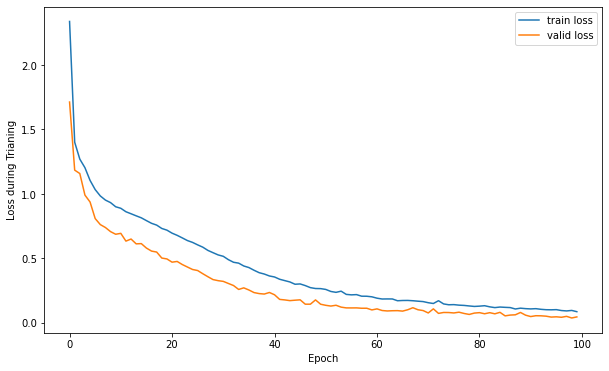

In [27]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss during Trianing')

Text(0, 0.5, 'Accuracy during Trianing')

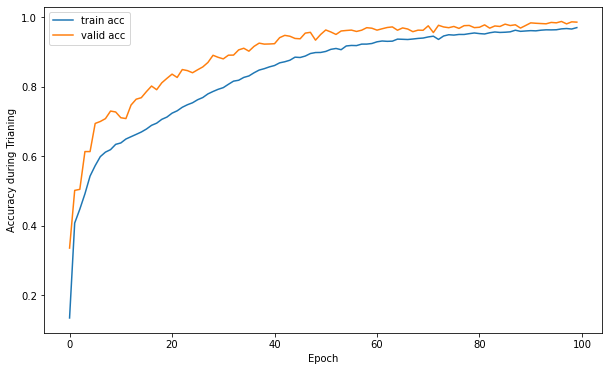

In [28]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy during Trianing')

In [29]:
def predict_model(model, X_test):
    
    model.eval()
    
    x = torch.tensor(X_test).float()
            
    out = model(x.cuda(cuda))
    pred = torch.max(out, 1)[1]
    
    return pred.cpu().numpy()

In [30]:
X_test = X_test.transpose(0,2,1)
y_pred = predict_model(model,X_test)

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       118
           1       0.98      1.00      0.99        92
           2       0.85      1.00      0.92        85
           3       0.03      1.00      0.07        26
           4       0.32      1.00      0.49        30
           5       0.01      1.00      0.03        30
           6       0.88      1.00      0.94        22
           7       0.48      1.00      0.65        30
           8       0.73      1.00      0.85        30
           9       0.08      1.00      0.14        30
          10       1.00      0.53      0.70      7452

    accuracy                           0.56      7945
   macro avg       0.58      0.96      0.61      7945
weighted avg       0.98      0.56      0.70      7945



Text(33.0, 0.5, 'predicted')

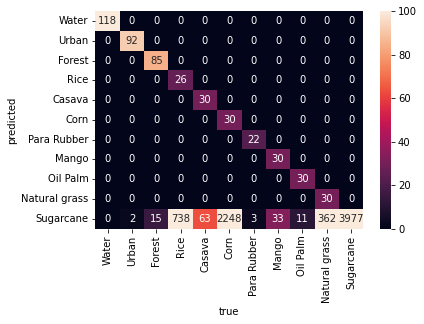

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix_plant = confusion_matrix(y_test, y_pred)
xticklabels = ["Water", "Urban", "Forest", "Rice", "Casava", "Corn", "Para Rubber", "Mango", "Oil Palm", "Natural grass", "Sugarcane"]
yticklabels = ["Water", "Urban", "Forest", "Rice", "Casava", "Corn", "Para Rubber", "Mango", "Oil Palm", "Natural grass", "Sugarcane"]

sns.heatmap(cf_matrix_plant, fmt="d",vmax=100 ,annot=True,xticklabels=xticklabels, yticklabels=yticklabels)
plt.xlabel('true')
plt.ylabel('predicted')